<a href="https://colab.research.google.com/github/LucasMatuszewski/Python-colab-notebooks/blob/main/notebooks/Polish_distil_whisper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq datasets
!pip install -qq jiwer
!pip install -qq evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
from IPython.display import display, HTML
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline,  WhisperForConditionalGeneration, WhisperProcessor
from datasets import load_dataset, Audio
from evaluate import load
wer = load("wer")
import torch
from tqdm import tqdm
import time
import random


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# The tests were conducted on the basis of 1,500 randomly selected records from the common voice dataset.

In [ ]:
cv_13 = load_dataset("mozilla-foundation/common_voice_13_0", "pl", split="test")
random.seed(42)
cv_13 = cv_13.select( random.sample(range(0, len(cv_13)), 1500))
cv_13 = cv_13.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
def map_to_pred(batch, pipe_whisper, model_name):
    start = time.time()
    transcription = pipe_whisper(batch["audio"]['array'], generate_kwargs={"language": "pl"})['text']
    end = time.time()

    batch[f"{model_name}_time"] = end - start
    batch[model_name] = transcription
    batch[f"{model_name}_wer"]  = wer.compute(references=[batch["sentence"]], predictions=[batch[model_name]])

    return batch

# Whisper models

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

In [ ]:
model_params = {}
for model in ["openai/whisper-large-v3", "openai/whisper-medium", "openai/whisper-small", "openai/whisper-base", "openai/whisper-tiny"]:
    print(f"*** {model} ***")
    pipe = pipeline(
      "automatic-speech-recognition",
      model= model,
      max_new_tokens=128,
      device=device,
      torch_dtype=torch_dtype
    )
    model_params[model.split("/")[1]] = round(sum(p.numel() for p in pipe.model.parameters())/1_000_000)

    cv_13 = cv_13.map(lambda x: map_to_pred(x, pipe, model.split("/")[1]))

*** openai/whisper-large-v3 ***


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


*** openai/whisper-medium ***


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

*** openai/whisper-small ***


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

*** openai/whisper-base ***


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

*** openai/whisper-tiny ***


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

# Polish distill-whisper-large-V3

In [ ]:
model_id = "Aspik101/distil-whisper-large-v3-pl"

# load the model + processor
model =  AutoModelForSpeechSeq2Seq.from_pretrained(model_id,  torch_dtype=torch_dtype)
model = model.to(device)
processor = AutoProcessor.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
!nvidia-smi

Thu Jan 11 14:24:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0              27W /  70W |   1667MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    torch_dtype=torch_dtype,
    device="cuda")
# model_params["distiller-whisper-v3-pl"] = round(sum(p.numel() for p in pipe.model.parameters())/1_000_000)

In [ ]:
def map_to_pred_pipe(batch):
    start = time.time()

    audio = batch["audio"]
    batch["distiller-whisper-v3-pl"] = pipe(audio['array'])['text']

    end = time.time()
    batch["distiller-whisper-v3-pl_time"] = end - start
    batch["distiller-whisper-v3-pl_wer"]  = wer.compute(references=[batch["sentence"]], predictions=[batch["distiller-whisper-v3-pl"]])


    return batch

In [ ]:
cv_13 = cv_13.map(map_to_pred_pipe)

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
cv_13pd = pd.DataFrame(cv_13)

# Model params

Text(0.5, 1.0, 'Model params')

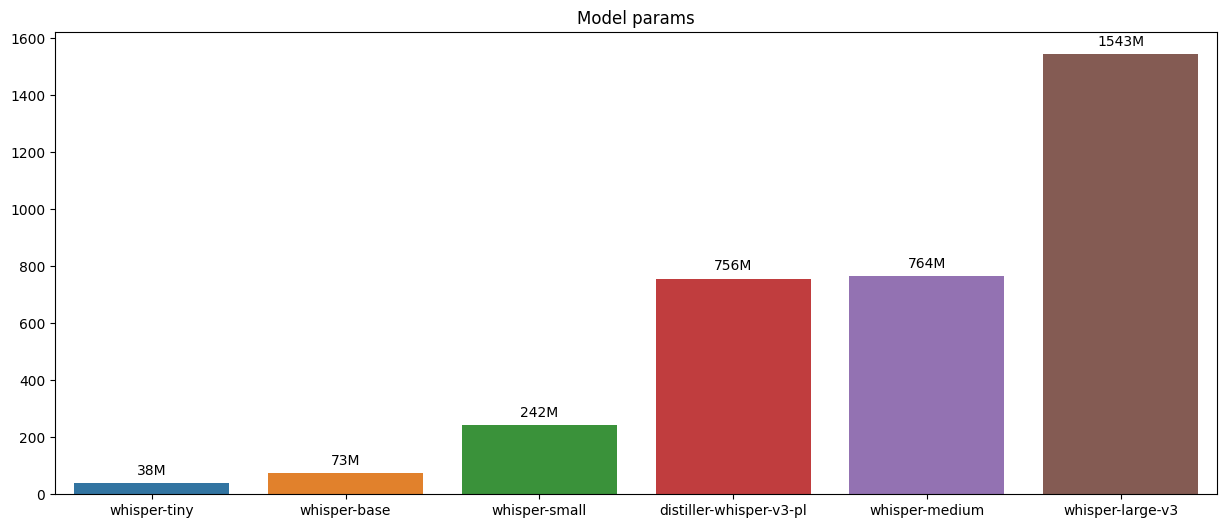

In [ ]:
plt.figure(figsize = (15, 6))
splot = sns.barplot(x = list(model_params.keys()), y = list(model_params.values()),  order =  [model for model, size in sorted(model_params.items(), key = lambda x: x[1], reverse = False)])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f') + "M",
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')
plt.title("Model params")

# WER metric

In [ ]:
model_col = ["whisper-large-v3", "whisper-medium", "whisper-small", "whisper-base", "whisper-tiny"]
model_col += ["distiller-whisper-v3-pl"]

### WER metric calculated on the entire data sample
wer_all = {}
for model in model_col:
    wer_all[model] = round(wer.compute(references=cv_13pd["sentence"], predictions=cv_13pd[model]),2)

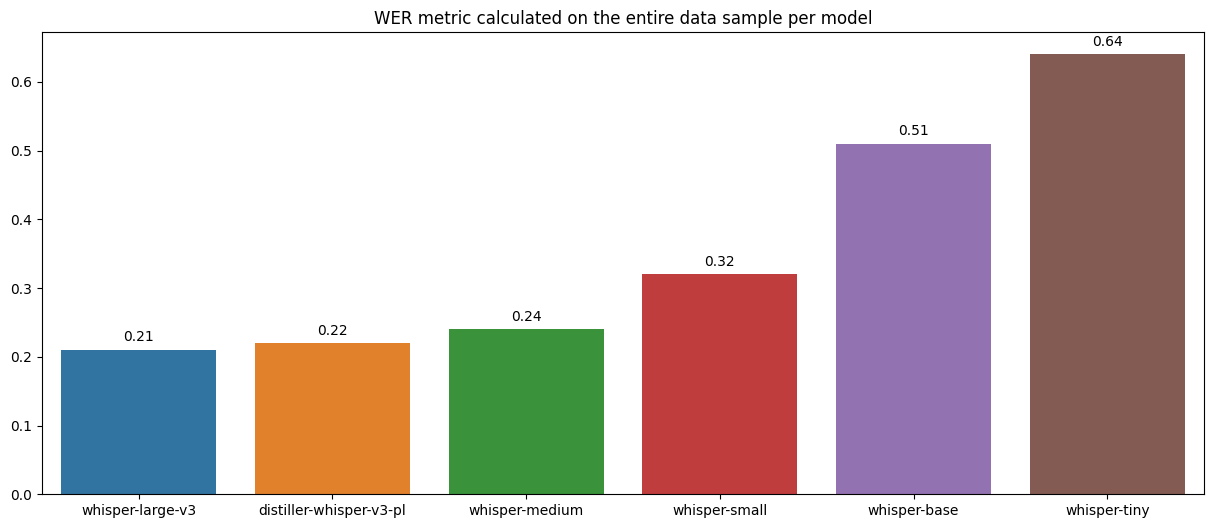

In [ ]:
plt.figure(figsize = (15, 6))
splot = sns.barplot(x = list(wer_all.keys()), y = list(wer_all.values()),  order =  [model for model, wer in sorted(wer_all.items(), key = lambda x: x[1], reverse = False)])
plt.title("WER metric calculated on the entire data sample per model")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

WER metric calculated separately for each record per model


WER                                          
                              count  mean   std  min   25%   50%   75%    max
Model                                                                        
distiller-whisper-v3-pl_wer  1500.0  0.25  0.25  0.0  0.07  0.20  0.33   2.00
whisper-base_wer             1500.0  0.55  1.54  0.0  0.27  0.50  0.67  58.17
whisper-large-v3_wer         1500.0  0.23  0.44  0.0  0.00  0.17  0.33  14.80
whisper-medium_wer           1500.0  0.26  0.24  0.0  0.08  0.20  0.38   1.75
whisper-small_wer            1500.0  0.34  0.39  0.0  0.14  0.29  0.50  10.64
whisper-tiny_wer             1500.0  0.65  0.97  0.0  0.40  0.60  0.80  26.29

Text(0.5, 1.0, 'WER metric calculated separately for each record per model')

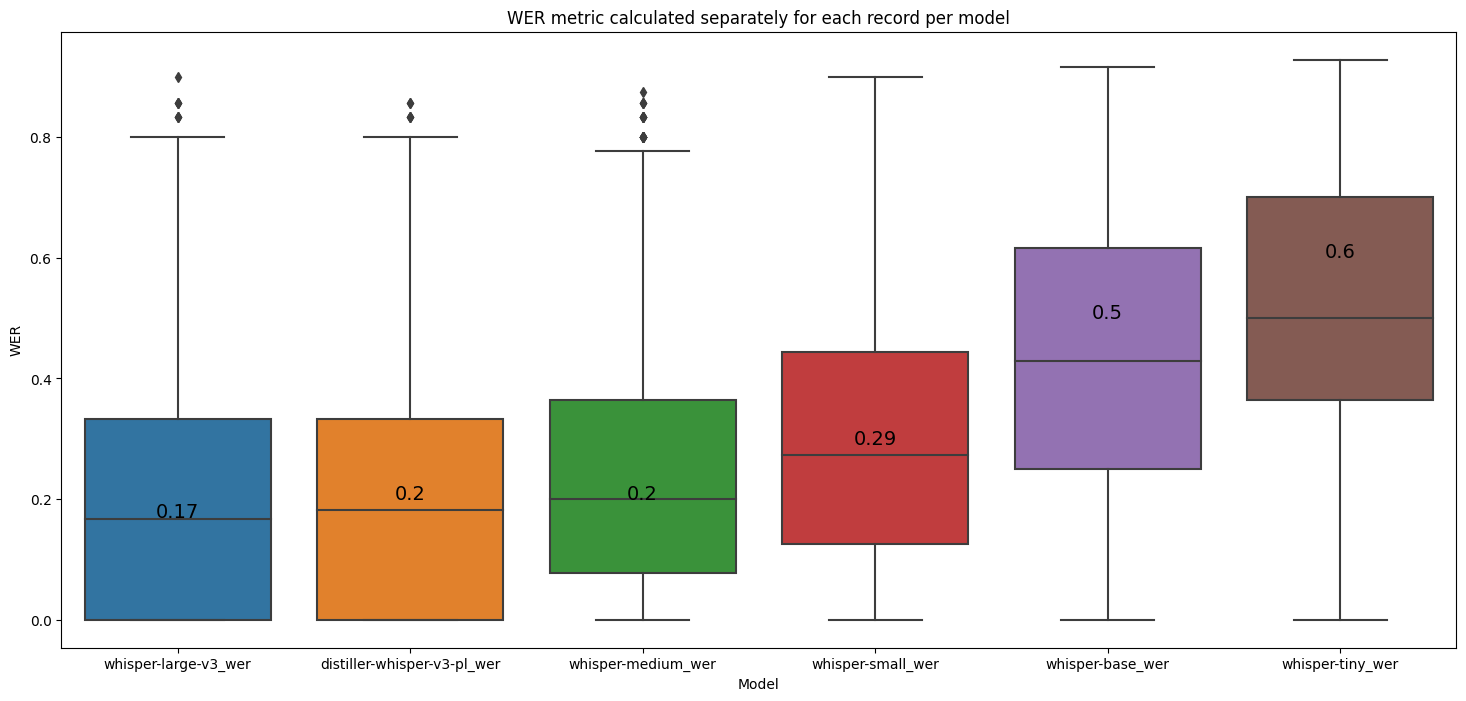

In [ ]:
### WER metric calculated separately for each record
print("WER metric calculated separately for each record per model")
wer_col = [col for col in cv_13pd.columns if "wer" in col]
wer_comparison = cv_13pd[wer_col].melt()
wer_comparison.columns = ['Model', 'WER']
display(pd.DataFrame(wer_comparison).groupby(['Model']).describe().round(2))

model_median = pd.DataFrame(wer_comparison).groupby(['Model']).median().sort_values("WER")
medians = model_median['WER'].round(2).tolist()

plt.figure(figsize = (18, 8))
box = sns.boxplot(x = 'Model', y = 'WER', data = wer_comparison[wer_comparison['WER'] < 1], order = model_median.index)
for i in range(len(medians)):
    box.annotate(medians[i], xy = (i, medians[i]), horizontalalignment = 'center',  fontsize=14)
plt.title("WER metric calculated separately for each record per model")

# Time of processed

In [ ]:
time_col = [col for col in cv_13pd.columns if "time" in col]
time_comparison = cv_13pd[time_col].melt()
time_comparison.columns = ['Model', 'time']

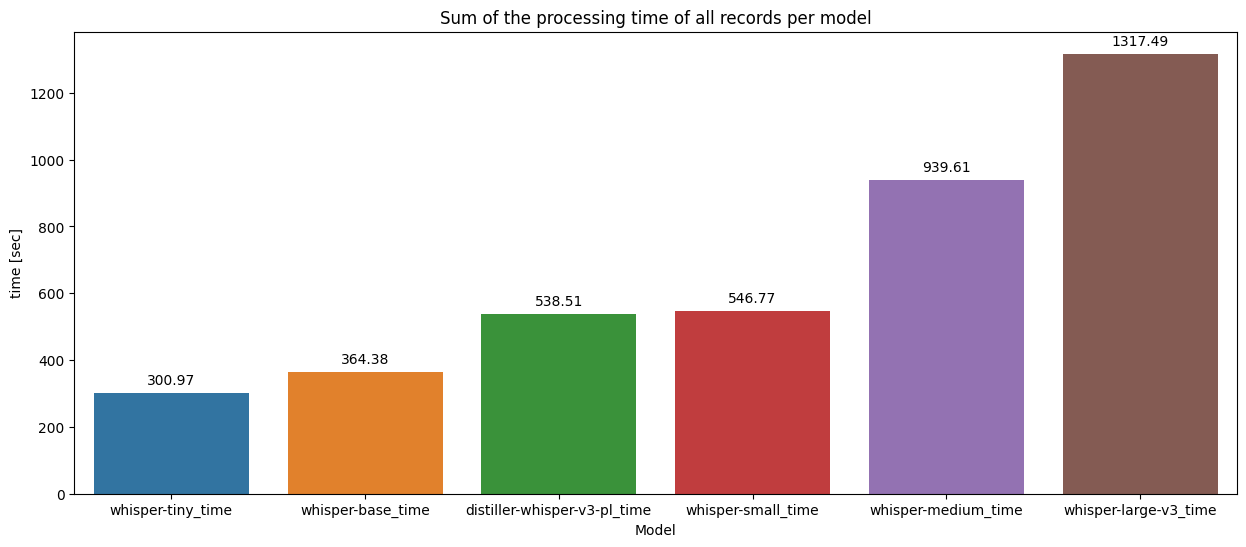

In [ ]:
processed_time = time_comparison.groupby("Model")['time'].sum().reset_index().sort_values("time")
plt.figure(figsize = (15, 6))
splot = sns.barplot(x = "Model", y = "time", data = processed_time)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')
plt.title("Sum of the processing time of all records per model")
plt.ylabel("time [sec]");

WER metric calculated separately for each record


time                                      \
                               count  mean   std   min   25%   50%   75%   
Model                                                                      
distiller-whisper-v3-pl_time  1500.0  0.36  0.04  0.28  0.33  0.36  0.38   
whisper-base_time             1500.0  0.24  0.11  0.12  0.20  0.23  0.27   
whisper-large-v3_time         1500.0  0.88  0.38  0.43  0.69  0.84  1.01   
whisper-medium_time           1500.0  0.63  0.17  0.30  0.50  0.60  0.73   
whisper-small_time            1500.0  0.36  0.15  0.17  0.29  0.35  0.42   
whisper-tiny_time             1500.0  0.20  0.08  0.10  0.17  0.19  0.22   

                                     
                                max  
Model                                
distiller-whisper-v3-pl_time   0.50  
whisper-base_time              2.78  
whisper-large-v3_time         12.44  
whisper-medium_time            1.36  
whisper-small_time             5.06  
whisper-tiny_time              2.01

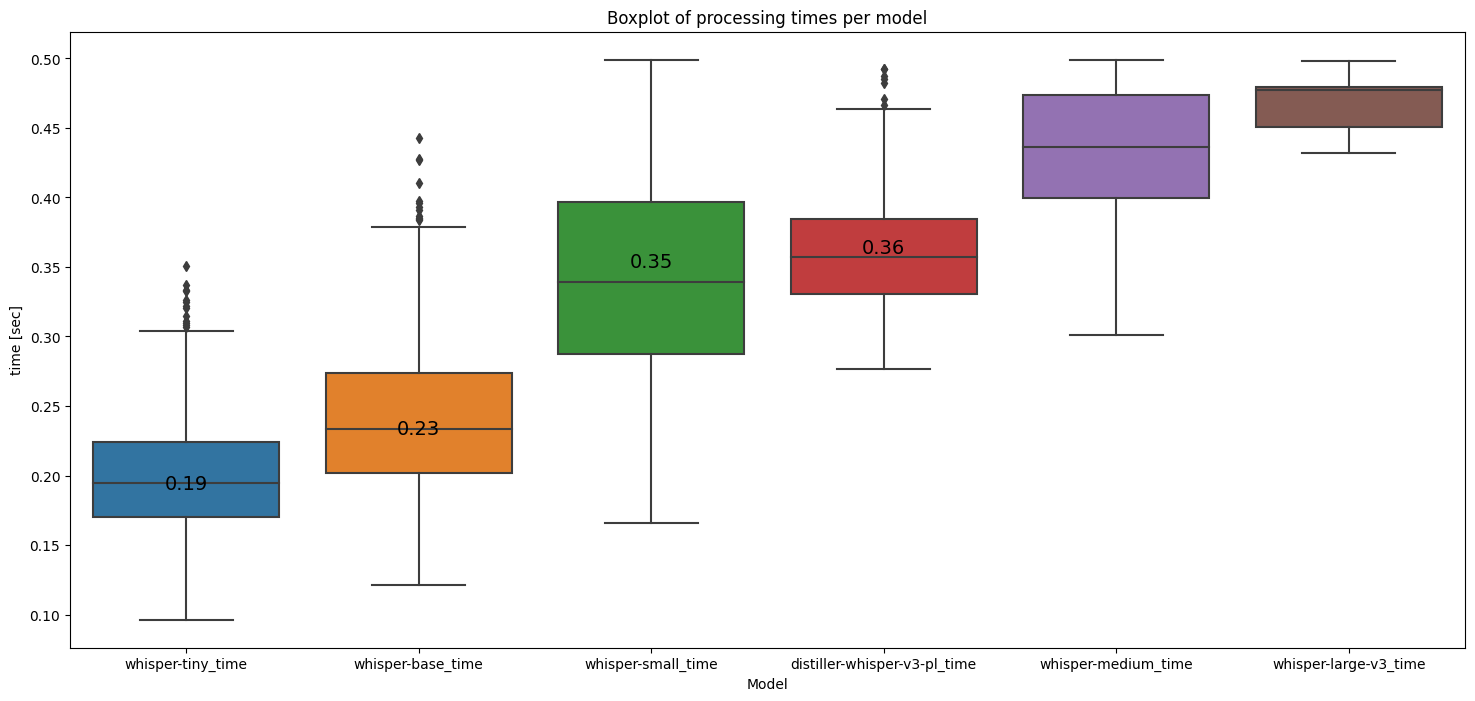

In [ ]:
print("WER metric calculated separately for each record")
display(pd.DataFrame(time_comparison).groupby(['Model']).describe().round(2))

model_median = pd.DataFrame(time_comparison).groupby(['Model']).median().sort_values("time")
medians = model_median['time'].round(2).tolist()

plt.figure(figsize = (18, 8))
box = sns.boxplot(x = 'Model', y = 'time', data = time_comparison[time_comparison['time'] < 0.5], order = model_median.index)
for i in range(len(medians)):
    box.annotate(medians[i], xy = (i, medians[i]), horizontalalignment = 'center',  fontsize=14)
plt.title("Boxplot of processing times per model")
plt.ylabel("time [sec]");

In [ ]:
processed_time['Model'] = processed_time['Model'].str.replace("_time","")
processed_time['model_params'] = processed_time['Model'].map(model_params)
processed_time['WER'] = processed_time['Model'].map(wer_all)
processed_time['time'] = processed_time['time'].round(2)
processed_time.sort_values("WER")

,Model,time,model_params,WER
2,whisper-large-v3,1317.49,1543,0.21
0,distiller-whisper-v3-pl,538.51,756,0.22
3,whisper-medium,939.61,764,0.24
4,whisper-small,546.77,242,0.32
1,whisper-base,364.38,73,0.51
5,whisper-tiny,300.97,38,0.64


The distiller-whisper-v3-pl model provides comparable accuracy to the whisper-large-v3 model with a WER of 0.22, while significantly reducing processing time and the number of parameters, indicating high efficiency. With the best WER at 0.21, whisper-large-v3 is the most accurate, but it is also the most resource-intensive. Comparatively, models from whisper-medium to whisper-tiny offer varying levels of accuracy with reduced time and resource consumption. In the context of the Polish language, distiller-whisper-v3-pl is particularly recommended, combining speed with high accuracy, making it an attractive choice for speech recognition applications in this language.